In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader.data as web
import datetime
from scipy.stats import skew, kurtosis

/tmp/ipython-input-17-2824293103.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, interval = '1d', start= START, end= TODAY)
[*********************100%***********************]  1 of 1 completed


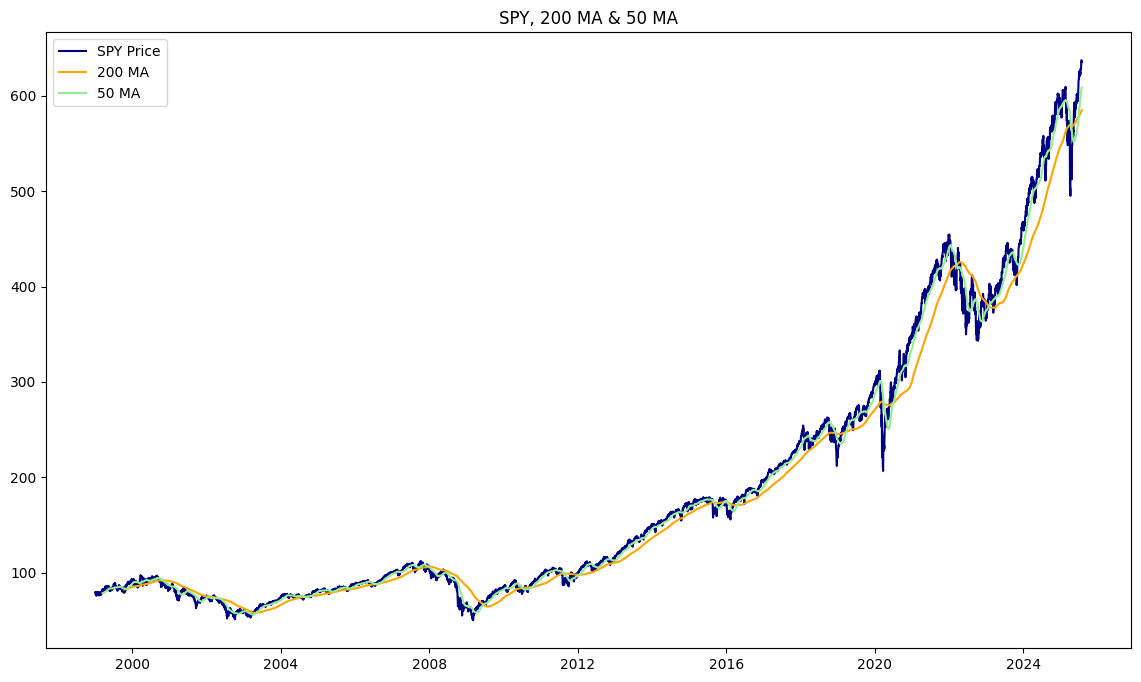

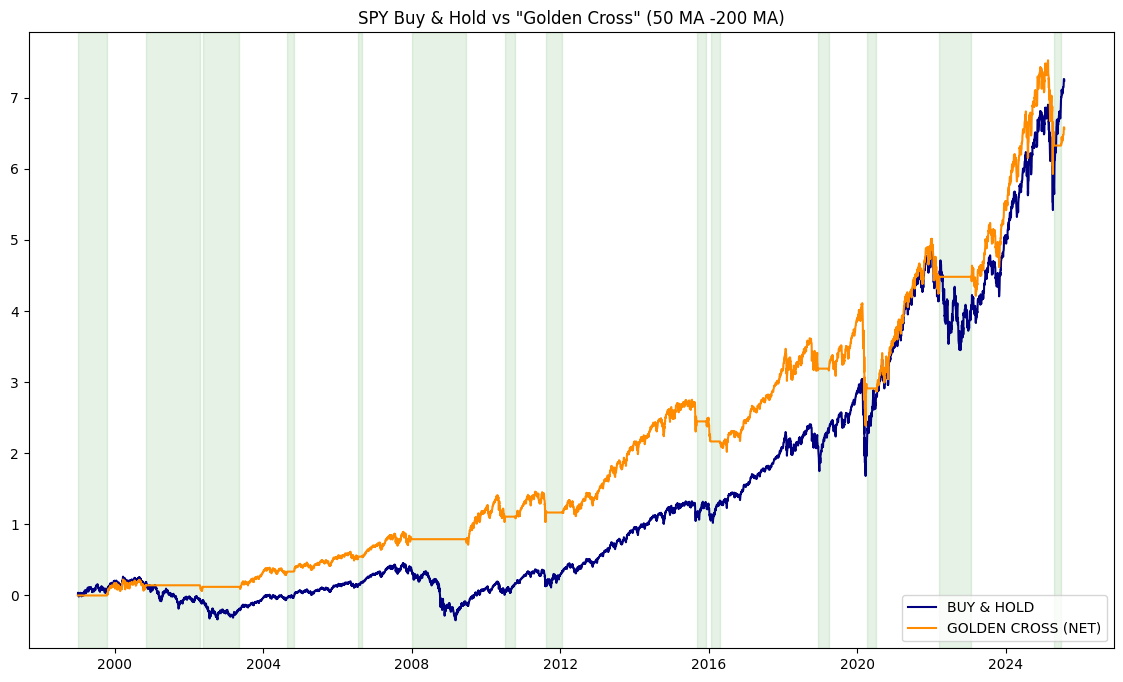

Strategy vs Buy & Hold
Asset Cumulative Return: 7.237580851211847
Strategy Cumulative Return: 6.560612708995947
Asset Max Drawdown: -0.5518946740397543
Strategy Max Drawdown: -0.3371727015954604
Asset Sharpe: 0.5062255627944232
Strategy Sharpe: 0.6423545368239244


In [17]:
TICKER = 'SPY'
COMMISSION = 0.001
SLOWWINDOW = 200
FASTWINDOW = 50
LOOKBACK = -1
START = '1999-01-01'
TODAY = datetime.date.today()

def get_data():
  df = yf.download(TICKER, interval = '1d', start= START, end= TODAY)
  df = df.dropna()
  return df

def add_mas(df, fast, slow):
  df['fastma'] = df['Close'].rolling(window=fast).mean()
  df['slowma'] = df['Close'].rolling(window=slow).mean()
  subsection = df.iloc[-LOOKBACK :, :]
  plt.figure(figsize=(14, 8))
  plt.plot(subsection['Close'], color='navy')
  plt.plot(subsection['slowma'], color='orange')
  plt.plot(subsection['fastma'], color='lightgreen')
  plt.legend([f'{TICKER} Price', f'{SLOWWINDOW} MA', f'{FASTWINDOW} MA'])
  plt.title(f'{TICKER}, {SLOWWINDOW} MA & {FASTWINDOW} MA')
  plt.savefig(f'{TICKER} & MAs: {START}-{TODAY}')
  return df

def add_strategy(df):
  df.columns = df.columns.get_level_values(0)
  df.index = pd.to_datetime(df.index)
  df['strategy'] = np.where(df['fastma'] > df['slowma'] , 1, 0)
  df['strategy'] = df['strategy'].shift(1)
  return df

def test_strategy(df):
  df['asset_returns'] = df['Close'].pct_change()
  df['strategy_returns'] = df['asset_returns'] * df['strategy'] - (df['strategy'] - df['strategy'].shift(1)).abs() * COMMISSION

  df['asset_cumulative'] = ((1 + df['asset_returns']).cumprod() - 1)
  df['strategy_cumulative'] = ((1 + df['strategy_returns']).cumprod() - 1)


  #plot
  subsection = df.iloc[-LOOKBACK:]
  plt.figure(figsize=(14, 8))
  plt.plot(subsection['asset_cumulative'], color='navy')
  plt.plot(subsection['strategy_cumulative'], color='darkorange')
  plt.legend(['BUY & HOLD', 'GOLDEN CROSS (NET)'])
  plt.title(f'{TICKER} Buy & Hold vs "Golden Cross" ({FASTWINDOW} MA -{SLOWWINDOW} MA)')


  in_cash_periods = (subsection['strategy'] == 0).ne((subsection['strategy'] == 0).shift()).cumsum()
  for _, period in subsection[subsection['strategy'] == 0].groupby(in_cash_periods):
    plt.axvspan(period.index[0], period.index[-1], color='green', alpha=0.1)

  plt.savefig(f'Strategy Test {TICKER}: {START}-{TODAY}')
  plt.show()

  return df

def get_metrics(df):
  asset_cum_return = df['asset_cumulative'].iloc[-1]
  strategy_cum_return = df['strategy_cumulative'].iloc[-1]

  asset_sharpe = (df['asset_returns'].mean() / df['asset_returns'].std()) * np.sqrt(252)
  strategy_sharpe = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)

  asset_growth = (1 + df['asset_returns']).cumprod()
  strategy_growth = (1 + df['strategy_returns']).cumprod()

  asset_mdrawdown = (asset_growth / asset_growth.cummax() - 1).min()
  strategy_mdrawdown = (strategy_growth / strategy_growth.cummax() - 1).min()

  print('Strategy vs Buy & Hold')
  print(f'Asset Cumulative Return: {asset_cum_return}')
  print(f'Strategy Cumulative Return: {strategy_cum_return}')

  print(f'Asset Max Drawdown: {asset_mdrawdown}')
  print(f'Strategy Max Drawdown: {strategy_mdrawdown}')

  print(f'Asset Sharpe: {asset_sharpe}')
  print(f'Strategy Sharpe: {strategy_sharpe}')


def main():
  df = get_data()
  df = add_mas(df, FASTWINDOW, SLOWWINDOW)
  df = add_strategy(df)
  df = test_strategy(df)
  get_metrics(df)

  return df

df = main()

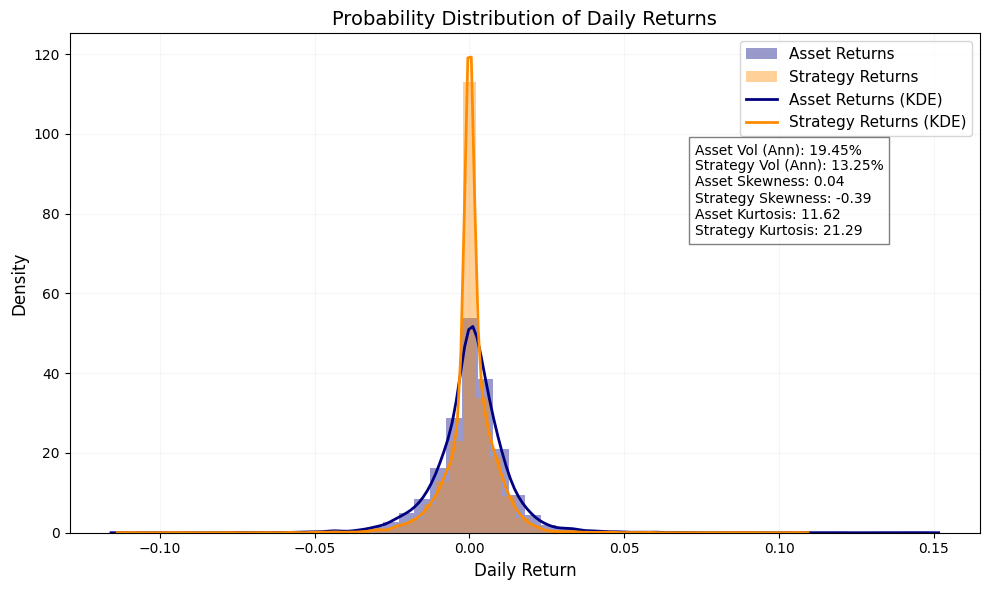

In [18]:
plt.figure(figsize=(10, 6))

# Histogram
plt.hist(df['asset_returns'], bins=50, alpha=0.4, label='Asset Returns', density=True, color='navy')
plt.hist(df['strategy_returns'], bins=50, alpha=0.4, label='Strategy Returns', density=True, color='darkorange')

# Density Curves
sns.kdeplot(df['asset_returns'].dropna(), label='Asset Returns (KDE)', color='navy', linewidth=2)
sns.kdeplot(df['strategy_returns'].dropna(), label='Strategy Returns (KDE)', color='darkorange', linewidth=2)

# Skewness and kurtosis
asset_vol_ann = df['asset_returns'].std()  * 100 * np.sqrt(252)
strategy_vol_ann = df['strategy_returns'].std() * 100 * np.sqrt(252)

asset_skew = skew(df['asset_returns'].dropna())
strategy_skew = skew(df['strategy_returns'].dropna())

asset_kurt = kurtosis(df['asset_returns'].dropna(), fisher=True)
strategy_kurt = kurtosis(df['strategy_returns'].dropna(), fisher=True)

# Show in graph
textstr = '\n'.join((
    f'Asset Vol (Ann): {asset_vol_ann:.2f}%',
    f'Strategy Vol (Ann): {strategy_vol_ann:.2f}%',
    f'Asset Skewness: {asset_skew:.2f}',
    f'Strategy Skewness: {strategy_skew:.2f}',
    f'Asset Kurtosis: {asset_kurt:.2f}',
    f'Strategy Kurtosis: {strategy_kurt:.2f}'
))

plt.gcf().text(0.7, 0.6, textstr, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.title('Probability Distribution of Daily Returns', fontsize=14)
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.1)
plt.tight_layout()

plt.savefig(f'Strategy Probability Distribution {TICKER}: {START}-{TODAY}')
plt.show()
